In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, float_precision="single")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  running_conf = Struct(backend="numba", signature=True, cache =True, float_precision="single")
  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()
  return (domain, ne, u, v, w, P)

In [2]:
import numba
import numpy as np
from numba import cuda, float32, int32

SM_SIZE = 1024

@cuda.jit
def prefix_sum_without_sum(arr, out):
  n = SM_SIZE
  temp = cuda.shared.array(shape=(SM_SIZE), dtype=int32)
  thid = cuda.threadIdx.x
  offset = 1

  block_id = cuda.blockIdx.x
  data_offset = block_id * cuda.blockDim.x * 2

  temp[2 * thid] = arr[data_offset + 2 * thid]
  temp[2 * thid + 1] = arr[data_offset + 2 * thid + 1]
  d = n >> 1
  while d > 0:
    cuda.syncthreads()
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      temp[bi] += temp[ai]
    offset *= 2
    d >>= 1
  cuda.syncthreads()

  if thid == 0:
    temp[n - 1] = 0
  
  d = 1
  while d < n:
    offset >>= 1
    cuda.syncthreads()
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      t = temp[ai]
      temp[ai] = temp[bi]
      temp[bi] += t
    d *= 2
  cuda.syncthreads()

  out[data_offset + 2 * thid] = temp[2 * thid]
  out[data_offset + 2 * thid + 1] = temp[2 * thid + 1]





@cuda.jit
def prefix_sum_with_sum(arr, out, sum):
  n = SM_SIZE
  temp = cuda.shared.array(shape=(SM_SIZE), dtype=int32)
  thid = cuda.threadIdx.x
  offset = 1

  block_id = cuda.blockIdx.x
  data_offset = block_id * cuda.blockDim.x * 2

  temp[2 * thid] = arr[data_offset + 2 * thid]
  temp[2 * thid + 1] = arr[data_offset + 2 * thid + 1]
  d = n >> 1
  while d > 0:
    cuda.syncthreads()
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      temp[bi] += temp[ai]
    offset *= 2
    d >>= 1
  cuda.syncthreads()

  if thid == 0:
    sum[block_id] = temp[n - 1]
    temp[n - 1] = 0
  
  d = 1
  while d < n:
    offset >>= 1
    cuda.syncthreads()
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      t = temp[ai]
      temp[ai] = temp[bi]
      temp[bi] += t
    d *= 2
  cuda.syncthreads()

  out[data_offset + 2 * thid] = temp[2 * thid]
  out[data_offset + 2 * thid + 1] = temp[2 * thid + 1]


@cuda.jit
def prefix_sum_add_sum(d_out, d_sum):
  i = cuda.grid(1)
  d_out[i] += d_sum[i // SM_SIZE]


#! note if prefix_sum_add_sum used SM_SIZE // 2 threads you use SM_SIZE = 2048
"""
SM_SIZE = 1024
max number of threads used = SM_SIZE // 2
max number of blocks used = size(d_in) // SM_SIZE
d_in, d_out max size is SM_SIZE * SM_SIZE * SM_SIZE and must be multiple of SM_SIZE
d_sum_1, d_out_2 must be of size SM_SIZE * SM_SIZE
d_out_3 must be of size SM_SIZE
details: https://developer.nvidia.com/gpugems/gpugems3/part-vi-gpu-computing/chapter-39-parallel-prefix-sum-scan-cuda
"""
def gpu_prefix_sum(d_in, d_out, d_sum_1, d_out_2, d_sum_2, d_out_3):
  nb_threads = SM_SIZE // 2
  size = d_in.shape[0]
  if d_in.shape[0] <= SM_SIZE * SM_SIZE:
    prefix_sum_with_sum[size // SM_SIZE, nb_threads](d_in, d_out, d_sum_1)
    cuda.synchronize()
    prefix_sum_without_sum[1, nb_threads](d_sum_1, d_out_2)
    cuda.synchronize()
    prefix_sum_add_sum[2 * size // SM_SIZE, nb_threads](d_out, d_out_2)
  else:
    prefix_sum_with_sum[size // SM_SIZE, nb_threads](d_in, d_out, d_sum_1)
    cuda.synchronize()
    prefix_sum_with_sum[SM_SIZE, nb_threads](d_sum_1, d_out_2, d_sum_2)
    cuda.synchronize()
    prefix_sum_without_sum[1, nb_threads](d_sum_2, d_out_3)
    cuda.synchronize()
    prefix_sum_add_sum[2 * SM_SIZE, nb_threads](d_out_2, d_out_3)
    cuda.synchronize()
    prefix_sum_add_sum[2  * size // SM_SIZE, nb_threads](d_out, d_out_2)
  cuda.synchronize()

In [3]:
dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre_hybrid.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square_larger.msh"
domain, ne, u, v, w, P = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
dfgdf
Local domain contruction ...


In [4]:
from manapy.solvers.ls import PETScKrylovSolver

# put this code to PETScKrylovSolver init function so bypass the import of petsc4py
"""
    # try_imports(['import petsc4py',],
    #             'cannot import petsc4py solver!')
    
    # from petsc4py import PETSc as petsc
    
    #self.petsc = petsc
    self.ksp   = None
    
    self.converged_reasons = {}                                                                                                                                                                             
    # for key, val in six.iteritems(petsc.KSP.ConvergedReason.__dict__):                                                                                                                                 
    #     if isinstance(val, int):                                                                                                                                                                       
    #         self.converged_reasons[val] = key    
"""

conf = Struct(reuse_mtx=True, scheme='diamond', verbose=False, precision="single")
L = PETScKrylovSolver(domain=domain, var=P, conf=conf)

SetUp the Linear system ...


In [5]:
from numba import cuda

def create_var(v):
  return (v, cuda.to_device(v))

host_cellfid, d_cellfid = create_var(L.domain.faces.cellid)
host_nodeidf, d_nodeidf = create_var(L.domain.faces.nodeid)
host_vertexn, d_vertexn = create_var(L.domain.nodes.vertex)
host_halofid, d_halofid = create_var(L.domain.faces.halofid)
host_haloext, d_haloext = create_var(L.domain.halos.halosext)
host_oldnamen, d_oldnamen = create_var(L.domain.nodes.oldname)
host_volume, d_volume = create_var(L.domain.cells.volume)
host_cellnid, d_cellnid = create_var(L.domain.nodes.cellid)
host_centerc, d_centerc = create_var(L.domain.cells.center)
host_centerh, d_centerh = create_var(L.domain.halos.centvol)
host_halonid, d_halonid = create_var(L.domain.nodes.halonid)
host_periodicnid, d_periodicnid = create_var(L.domain.nodes.periodicid)
host_centergn, d_centergn = create_var(L.domain.nodes.ghostcenter)
host_halocentergn, d_halocentergn = create_var(L.domain.nodes.haloghostcenter)
host_airDiamond, d_airDiamond = create_var(L.domain.faces.airDiamond)
host_lambda_x, d_lambda_x = create_var(L.domain.nodes.lambda_x)
host_lambda_y, d_lambda_y = create_var(L.domain.nodes.lambda_y)
host_lambda_z, d_lambda_z = create_var(L.domain.nodes.lambda_z)
host_number, d_number = create_var(L.domain.nodes.number)
host_R_x, d_R_x = create_var(L.domain.nodes.R_x)
host_R_y, d_R_y = create_var(L.domain.nodes.R_y)
host_R_z, d_R_z = create_var(L.domain.nodes.R_z)
host_param1, d_param1 = create_var(L.domain.faces.param1)
host_param2, d_param2 = create_var(L.domain.faces.param2)
host_param3, d_param3 = create_var(L.domain.faces.param3)
host_param4, d_param4 = create_var(L.domain.faces.param4)
host_shift, d_shift = create_var(L.domain.cells.shift)
host_nbelements, d_nbelements = create_var(L.localsize)
host_loctoglob, d_loctoglob = create_var(L.domain.cells.loctoglob)
host_BCdirichlet, d_BCdirichlet = create_var(L.var.BCdirichlet)
host_a_loc, d_a_loc = create_var(L._data)
host_irn_loc, d_irn_loc = create_var(L._row)
host_jcn_loc, d_jcn_loc = create_var(L._col)
host_matrixinnerfaces, d_matrixinnerfaces = create_var(L.matrixinnerfaces)
host_halofaces, d_halofaces = create_var(L.domain.halofaces)
host_dirichletfaces, d_dirichletfaces = create_var(L.var.dirichletfaces)


In [10]:
host_a_loc.dtype

dtype('float32')

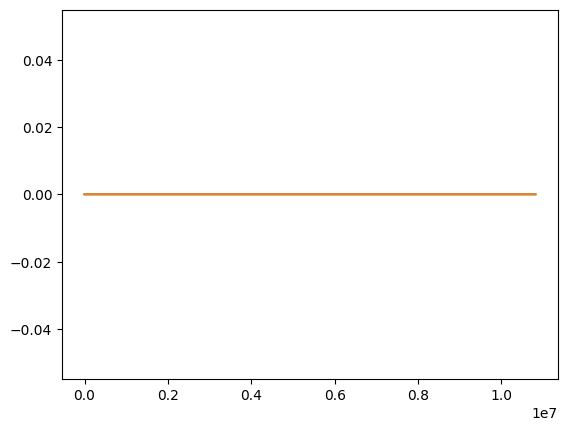

In [7]:
plt.plot(host_a_loc)
plt.plot(d_a_loc.copy_to_host())
plt.show()

In [11]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np


def get_triplet_2d(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', vertexn:'float[:,:]', halofid:'int32[:]',
                   haloext:'int32[:,:]', oldnamen:'uint32[:]', volume:'float[:]', 
                   cellnid:'int32[:,:]', centerc:'float[:,:]', centerh:'float[:,:]', halonid:'int32[:,:]', periodicnid:'int32[:,:]', 
                   centergn:'float[:,:,:]', halocentergn:'float[:,:,:]', airDiamond:'float[:]', 
                   lambda_x:'float[:]', lambda_y:'float[:]', lambda_z:'float[:]', number:'uint32[:]', R_x:'float[:]', R_y:'float[:]', 
                   R_z:'float[:]', param1:'float[:]', param2:'float[:]', param3:'float[:]', param4:'float[:]', shift:'float[:,:]',
                   nbelements:'int32', loctoglob:'int32[:]', BCdirichlet:'uint32[:]', a_loc:'float[:]', irn_loc:'int32[:]', jcn_loc:'int32[:]',
                   matrixinnerfaces:'uint32[:]', halofaces:'uint32[:]', dirichletfaces:'uint32[:]'):                                                                                                                                                                       
    
    
    def search_element(a:'int32[:]', target_value:'int32'):
        find = 0
        for val in a:
            if val == target_value:
                find = 1
                break
        return find
    center = np.zeros(2)
    parameters = np.zeros(2)
    cmpt = 0

    for i in matrixinnerfaces:
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]; parameters[1] = param2[i]
    
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
        
        cmptparam = 0
        for nod in nodeidf[i][:nodeidf[i][-1]]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0: 
                for j in range(cellnid[nod][-1]):
                    center[:] = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center[:] = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center[:] = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                    
                for j in range(periodicnid[nod][-1]):
                    if vertexn[nod][3] == 11 or vertexn[nod][3] == 22:
                        center[0] = centerc[periodicnid[nod][j]][0]  + shift[periodicnid[nod][j]][0]
                        center[1] = centerc[periodicnid[nod][j]][1]  
                    if vertexn[nod][3] == 33 or vertexn[nod][3] == 44:
                        center[0] = centerc[periodicnid[nod][j]][0]  
                        center[1] = centerc[periodicnid[nod][j]][1]  + shift[periodicnid[nod][j]][1]
                    
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[periodicnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = loctoglob[periodicnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                
                for j in range(halonid[nod][-1]):
                    center[:] = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
            cmptparam =+1
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1

        # right cell------------------------------------------------------
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_leftglob
        value =  -1. * param1[i] / volume[c_right]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
    
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_rightglob
        value =  -1. * param3[i] / volume[c_right]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
    
    for i in halofaces:
        
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]; parameters[1] = param2[i]
        
        c_rightglob = haloext[halofid[i]][0]
        c_right     = halofid[i]
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value =  param1[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1

        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
        
        cmptparam = 0
        for nod in nodeidf[i][:nodeidf[i][-1]]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0: 
                for j in range(cellnid[nod][-1]):
                    center[:] = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
                    
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center[:] = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center[:] = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value
                        cmpt = cmpt + 1

                for j in range(halonid[nod][-1]):
                    center[:] = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value
                    cmpt = cmpt + 1
            cmptparam +=1
            
    for i in dirichletfaces:
        
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = -1. * param3[i] / volume[c_left]
        a_loc[cmpt] = value
        cmpt = cmpt + 1


In [12]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

numba_get_triplet_2d = numba.jit(get_triplet_2d, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_numba_get_triplet_2d():
  numba_get_triplet_2d(
    host_cellfid,
    host_nodeidf,
    host_vertexn,
    host_halofid,
    host_haloext,
    host_oldnamen,
    host_volume,
    host_cellnid,
    host_centerc,
    host_centerh,
    host_halonid,
    host_periodicnid,
    host_centergn,
    host_halocentergn,
    host_airDiamond,
    host_lambda_x,
    host_lambda_y,
    host_lambda_z,
    host_number,
    host_R_x,
    host_R_y,
    host_R_z,
    host_param1,
    host_param2,
    host_param3,
    host_param4,
    host_shift,
    host_nbelements,
    host_loctoglob,
    host_BCdirichlet,
    host_a_loc,
    host_irn_loc,
    host_jcn_loc,
    host_matrixinnerfaces,
    host_halofaces,
    host_dirichletfaces,
  )


In [13]:
#time taken by cpu_numba_get_triplet_2d

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)

%timeit cpu_numba_get_triplet_2d()

99.7 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


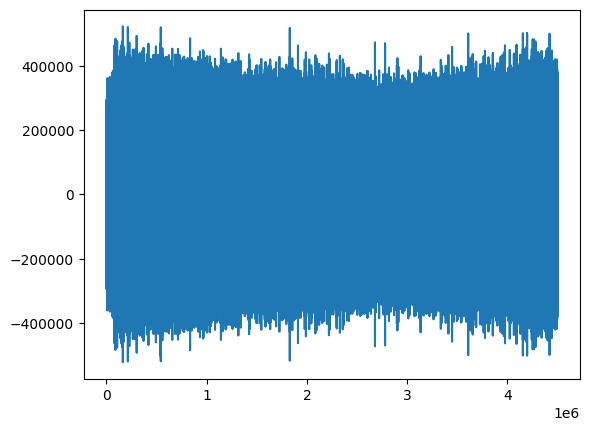

In [9]:
plt.plot(host_a_loc)

In [9]:
print(host_irn_loc.shape, host_jcn_loc.shape, host_a_loc.shape)
print(host_halonid.shape, host_periodicnid.shape, host_halocentergn.shape)
print(host_nodeidf.shape, host_cellnid.shape, host_centergn.shape)
print(host_halocentergn.shape)
print(host_periodicnid[0].shape)
print(host_halonid[0].shape)
print(max(host_matrixinnerfaces.shape[0], host_halofaces.shape[0] ,host_dirichletfaces.shape[0]))

print()
print(len(host_centergn[1]))
print(len(host_halocentergn[1]))


(4496676,) (4496676,) (4496676,)
(53314, 2) (53314, 2) (53314, 1, 5)
(159139, 3) (53314, 10) (53314, 2, 5)
(53314, 1, 5)
(2,)
(2,)
158339

2
1


In [14]:
#create irn_loc  jcn_loc   a_loc for each thread

#!must be calculated
max_size = 40 #assume that each thread will use `max_size` (cmpt < max_size for each thread)
number_of_threads = max(host_matrixinnerfaces.shape[0], host_halofaces.shape[0] ,host_dirichletfaces.shape[0])
arr_size = number_of_threads // max_size + 1


host_a_loc_2 = np.zeros(shape=(max_size, number_of_threads), dtype=np.float32)
host_jcn_loc_2 = np.zeros(shape=(max_size, number_of_threads), dtype=np.int32)
host_irn_loc_2 = np.zeros(shape=(max_size, number_of_threads), dtype=np.int32)

host_a_loc_2 = host_a_loc_2.T
host_jcn_loc_2 = host_jcn_loc_2.T
host_irn_loc_2 = host_irn_loc_2.T

d_a_loc_2 = cuda.to_device(host_a_loc_2)
d_jcn_loc_2 = cuda.to_device(host_jcn_loc_2)
d_irn_loc_2 = cuda.to_device(host_irn_loc_2)

# d_a_loc_2 = cuda.to_device(np.zeros((number_of_threads, max_size), dtype=np.float64))
# d_jcn_loc_2 = cuda.to_device(np.zeros((number_of_threads, max_size), dtype=np.int32))
# d_irn_loc_2 = cuda.to_device(np.zeros((number_of_threads, max_size), dtype=np.int32))

#array to store length for each thread
size_of_d_arr_length = (number_of_threads + 1) // SM_SIZE + int((number_of_threads + 1) % SM_SIZE != 0) 
size_of_d_arr_length = size_of_d_arr_length * SM_SIZE
d_arr_length = cuda.to_device(np.zeros(size_of_d_arr_length, dtype=int))

print("size of arr_length => ", d_arr_length.shape)
print(number_of_threads)



size of arr_length =>  (158720,)
158339


In [15]:
@cuda.jit(device=True)
def search_element(a:'int32[:]', target_value:'int32'):
    for i in range(a.shape[0]):
        if a[i] == target_value:
            return True
    return False

@cuda.jit
def kernel_get_triplet_2d(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', vertexn:'float[:,:]', halofid:'int32[:]',
                   haloext:'int32[:,:]', oldnamen:'uint32[:]', volume:'float[:]', 
                   cellnid:'int32[:,:]', centerc:'float[:,:]', centerh:'float[:,:]', halonid:'int32[:,:]', periodicnid:'int32[:,:]', 
                   centergn:'float[:,:,:]', halocentergn:'float[:,:,:]', airDiamond:'float[:]', 
                   lambda_x:'float[:]', lambda_y:'float[:]', lambda_z:'float[:]', number:'uint32[:]', R_x:'float[:]', R_y:'float[:]', 
                   R_z:'float[:]', param1:'float[:]', param2:'float[:]', param3:'float[:]', param4:'float[:]', shift:'float[:,:]',
                   nbelements:'int32', loctoglob:'int32[:]', BCdirichlet:'uint32[:]', a_loc:'float[:]', irn_loc:'int32[:]', jcn_loc:'int32[:]',
                   matrixinnerfaces:'uint32[:]', halofaces:'uint32[:]', dirichletfaces:'uint32[:]',
                   arr_length:'uint32[:]'
                   ):                                                                                                                                                                       
    
    
    idx = cuda.grid(1)

    center = numba.cuda.local.array(2, numba.float32)
    parameters = numba.cuda.local.array(2, numba.float32)
    cmpt = 0
    #!center = np.zeros(2)
    #!parameters = np.zeros(2)

    #!irn_loc[cmpt] => irn_loc[idx][cmpt]

    if idx < matrixinnerfaces.shape[0]:
        i = matrixinnerfaces[idx]
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]
        parameters[1] = param2[i]

        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        
        irn_loc[idx][cmpt] = c_leftglob
        jcn_loc[idx][cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[idx][cmpt] = value
        cmpt = cmpt + 1
        
        cmptparam = 0
        for nod_i in range(nodeidf[i][-1]):
            nod = nodeidf[i][nod_i]
            if search_element(BCdirichlet, oldnamen[nod]) == False: 
                for j in range(cellnid[nod][-1]):
                    center[0] = centerc[cellnid[nod][j]][0]
                    center[1] = centerc[cellnid[nod][j]][1]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                                lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    
                    
                    # irn_loc[idx][cmpt] = c_leftglob
                    # jcn_loc[idx][cmpt] = loctoglob[cellnid[nod][j]]
                    # a_loc[idx][cmpt] = value
                    # cmpt = cmpt + 1
                    # #right cell-----------------------------------                                                                                              
                    # value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    # irn_loc[idx][cmpt] = c_rightglob
                    # jcn_loc[idx][cmpt] = loctoglob[cellnid[nod][j]]
                    # a_loc[idx][cmpt] = value
                    # cmpt = cmpt + 1
                    
                    irn_loc[idx][cmpt] = c_leftglob
                    irn_loc[idx][cmpt + 1] = c_rightglob
                    jcn_loc[idx][cmpt] = loctoglob[cellnid[nod][j]]
                    jcn_loc[idx][cmpt + 1] = loctoglob[cellnid[nod][j]]
                    a_loc[idx][cmpt] = value
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    a_loc[idx][cmpt + 1] = value
                    cmpt = cmpt + 2
                    #right cell-----------------------------------                                                                                              
                    #cmpt = cmpt + 1
                
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center[0] = centergn[nod][j][0]
                        center[1] = centergn[nod][j][1]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                    lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[idx][cmpt] = c_leftglob
                        jcn_loc[idx][cmpt] = loctoglob[index]
                        a_loc[idx][cmpt] = value
                        cmpt = cmpt + 1
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        irn_loc[idx][cmpt] = c_rightglob
                        jcn_loc[idx][cmpt] = loctoglob[index]
                        a_loc[idx][cmpt] = value
                        cmpt = cmpt + 1
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center[0] = halocentergn[nod][j][0]
                        center[1] = halocentergn[nod][j][1]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                    lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[idx][cmpt] = c_leftglob
                        jcn_loc[idx][cmpt] = haloext[index][0]
                        a_loc[idx][cmpt] = value
                        cmpt = cmpt + 1
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        irn_loc[idx][cmpt] = c_rightglob
                        jcn_loc[idx][cmpt] = haloext[index][0]
                        a_loc[idx][cmpt] = value
                        cmpt = cmpt + 1
                    
                for j in range(periodicnid[nod][-1]):
                    if vertexn[nod][3] == 11 or vertexn[nod][3] == 22:
                        center[0] = centerc[periodicnid[nod][j]][0]  + shift[periodicnid[nod][j]][0]
                        center[1] = centerc[periodicnid[nod][j]][1]  
                    if vertexn[nod][3] == 33 or vertexn[nod][3] == 44:
                        center[0] = centerc[periodicnid[nod][j]][0]  
                        center[1] = centerc[periodicnid[nod][j]][1]  + shift[periodicnid[nod][j]][1]
                    
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                                lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[idx][cmpt] = c_leftglob
                    jcn_loc[idx][cmpt] = loctoglob[periodicnid[nod][j]]
                    a_loc[idx][cmpt] = value
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[idx][cmpt] = c_rightglob
                    jcn_loc[idx][cmpt] = loctoglob[periodicnid[nod][j]]
                    a_loc[idx][cmpt] = value
                    cmpt = cmpt + 1
                
                for j in range(halonid[nod][-1]):
                    center[0] = centerh[halonid[nod][j]][0]
                    center[1] = centerh[halonid[nod][j]][1]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                                lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[idx][cmpt] = c_leftglob
                    jcn_loc[idx][cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[idx][cmpt] = value
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[idx][cmpt] = c_rightglob
                    jcn_loc[idx][cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[idx][cmpt] = value
                    cmpt = cmpt + 1
            cmptparam =+1
        
        irn_loc[idx][cmpt] = c_leftglob
        jcn_loc[idx][cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[idx][cmpt] = value
        cmpt = cmpt + 1

        # right cell------------------------------------------------------
        irn_loc[idx][cmpt] = c_rightglob
        jcn_loc[idx][cmpt] = c_leftglob
        value =  -1. * param1[i] / volume[c_right]
        a_loc[idx][cmpt] = value
        cmpt = cmpt + 1

        irn_loc[idx][cmpt] = c_rightglob
        jcn_loc[idx][cmpt] = c_rightglob
        value =  -1. * param3[i] / volume[c_right]
        a_loc[idx][cmpt] = value
        cmpt = cmpt + 1
    
    if idx < halofaces.shape[0]:
        
        i = halofaces[idx]

        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]
        parameters[1] = param2[i]
        
        c_rightglob = haloext[halofid[i]][0]
        c_right     = halofid[i]
        
        irn_loc[idx][cmpt] = c_leftglob
        jcn_loc[idx][cmpt] = c_leftglob
        value =  param1[i] / volume[c_left]
        a_loc[idx][cmpt] = value
        cmpt = cmpt + 1

        irn_loc[idx][cmpt] = c_leftglob
        jcn_loc[idx][cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[idx][cmpt] = value
        cmpt = cmpt + 1
        
        cmptparam = 0
        for nod_i in range(nodeidf[i][-1]):
            nod = nodeidf[i][nod_i]
            if search_element(BCdirichlet, oldnamen[nod]) == False: 
                for j in range(cellnid[nod][-1]):
                    center[0] = centerc[cellnid[nod][j]][0]
                    center[1] = centerc[cellnid[nod][j]][1]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[idx][cmpt] = c_leftglob
                    jcn_loc[idx][cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[idx][cmpt] = value
                    cmpt = cmpt + 1
                    
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center[0] = centergn[nod][j][0]
                        center[1] = centergn[nod][j][1]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[idx][cmpt] = c_leftglob
                        jcn_loc[idx][cmpt] = loctoglob[index]
                        a_loc[idx][cmpt] = value
                        cmpt = cmpt + 1
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center[0] = halocentergn[nod][j][0]
                        center[1] = halocentergn[nod][j][1]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = np.int32(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[idx][cmpt] = c_leftglob
                        jcn_loc[idx][cmpt] = haloext[index][0]
                        a_loc[idx][cmpt] = value
                        cmpt = cmpt + 1

                for j in range(halonid[nod][-1]):
                    center[0] = centerh[halonid[nod][j]][0]
                    center[1] = centerh[halonid[nod][j]][1]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[idx][cmpt] = c_leftglob
                    jcn_loc[idx][cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[idx][cmpt] = value
                    cmpt = cmpt + 1
            cmptparam +=1

    if idx < dirichletfaces.shape[0]:
        i = dirichletfaces[idx]
        
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        irn_loc[idx][cmpt] = c_leftglob
        jcn_loc[idx][cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[idx][cmpt] = value
        cmpt = cmpt + 1
        
        irn_loc[idx][cmpt] = c_leftglob
        jcn_loc[idx][cmpt] = c_leftglob
        value = -1. * param3[i] / volume[c_left]
        a_loc[idx][cmpt] = value
        cmpt = cmpt + 1

    #! save the lenfth 
    arr_length[idx] = cmpt




In [ ]:
irn_loc.shape

In [6]:
@cuda.jit(device=True)
def search_element(a:'int32[:]', target_value:'int32'):
    for i in range(a.shape[0]):
        if a[i] == target_value:
            return True
    return False

@cuda.jit
def kernel_get_triplet_2d(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', vertexn:'float[:,:]', halofid:'int32[:]',
                   haloext:'int32[:,:]', oldnamen:'uint32[:]', volume:'float[:]', 
                   cellnid:'int32[:,:]', centerc:'float[:,:]', centerh:'float[:,:]', halonid:'int32[:,:]', periodicnid:'int32[:,:]', 
                   centergn:'float[:,:,:]', halocentergn:'float[:,:,:]', airDiamond:'float[:]', 
                   lambda_x:'float[:]', lambda_y:'float[:]', lambda_z:'float[:]', number:'uint32[:]', R_x:'float[:]', R_y:'float[:]', 
                   R_z:'float[:]', param1:'float[:]', param2:'float[:]', param3:'float[:]', param4:'float[:]', shift:'float[:,:]',
                   nbelements:'int32', loctoglob:'int32[:]', BCdirichlet:'uint32[:]', a_loc:'float[:]', irn_loc:'int32[:]', jcn_loc:'int32[:]',
                   matrixinnerfaces:'uint32[:]', halofaces:'uint32[:]', dirichletfaces:'uint32[:]',
                    shared_cmpt
                   ):                                                                                                                                                                       
    
    
    idx = cuda.grid(1)

    center = numba.cuda.local.array(2, numba.float32)
    parameters = numba.cuda.local.array(2, numba.float32)
    #cmpt[0] = 0
    #!center = np.zeros(2)
    #!parameters = np.zeros(2)

    #!irn_loc[cmpt[0]] => irn_loc[idx][cmpt[0]]

    if idx < matrixinnerfaces.shape[0]: 
        i = matrixinnerfaces[idx]
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]
        parameters[1] = param2[i]

        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        
        cmpt = cuda.atomic.add(shared_cmpt, 0, 1)
        print(cmpt)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value
        
        cmptparam = 0
        # for nod_i in range(nodeidf[i][-1]):
        #     nod = nodeidf[i][nod_i]
        #     if search_element(BCdirichlet, oldnamen[nod]) == False: 
        #         for j in range(cellnid[nod][-1]):
        #             center[0] = centerc[cellnid[nod][j]][0]
        #             center[1] = centerc[cellnid[nod][j]][1]
        #             xdiff = center[0] - vertexn[nod][0]
        #             ydiff = center[1] - vertexn[nod][1]
        #             alpha = (1. + lambda_x[nod]*xdiff + \
        #                         lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
        #             value =  alpha / volume[c_left] * parameters[cmptparam]
                    
                    
        #             # irn_loc[cmpt[0]] = c_leftglob
        #             # jcn_loc[cmpt[0]] = loctoglob[cellnid[nod][j]]
        #             # a_loc[cmpt[0]] = value
        #             # cuda.atomic.add(cmpt, 0, 1)
        #             # #right cell-----------------------------------                                                                                              
        #             # value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
        #             # irn_loc[cmpt[0]] = c_rightglob
        #             # jcn_loc[cmpt[0]] = loctoglob[cellnid[nod][j]]
        #             # a_loc[cmpt[0]] = value
        #             # cuda.atomic.add(cmpt, 0, 1)
                    
        #             irn_loc[cmpt[0]] = c_leftglob
        #             irn_loc[cmpt[0] + 1] = c_rightglob
        #             jcn_loc[cmpt[0]] = loctoglob[cellnid[nod][j]]
        #             jcn_loc[cmpt[0] + 1] = loctoglob[cellnid[nod][j]]
        #             a_loc[cmpt[0]] = value
        #             value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
        #             a_loc[cmpt[0] + 1] = value
        #             cmpt[0] = cmpt[0] + 2
        #             #right cell-----------------------------------                                                                                              
        #             #cuda.atomic.add(cmpt, 0, 1)
                
        #         for j in range(len(centergn[nod])):
        #             if centergn[nod][j][-1] != -1:
        #                 center[0] = centergn[nod][j][0]
        #                 center[1] = centergn[nod][j][1]
        #                 xdiff = center[0] - vertexn[nod][0]
        #                 ydiff = center[1] - vertexn[nod][1]
        #                 alpha = (1. + lambda_x[nod]*xdiff + \
        #                             lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
        #                 index = np.int32(centergn[nod][j][2])
        #                 value = alpha / volume[c_left] * parameters[cmptparam]
        #                 irn_loc[cmpt[0]] = c_leftglob
        #                 jcn_loc[cmpt[0]] = loctoglob[index]
        #                 a_loc[cmpt[0]] = value
        #                 cuda.atomic.add(cmpt, 0, 1)
        #                 #right cell-----------------------------------                                                                                              
        #                 value = -1. * alpha / volume[c_right] * parameters[cmptparam]
        #                 irn_loc[cmpt[0]] = c_rightglob
        #                 jcn_loc[cmpt[0]] = loctoglob[index]
        #                 a_loc[cmpt[0]] = value
        #                 cuda.atomic.add(cmpt, 0, 1)
                        
        #         for j in range(len(halocentergn[nod])):
        #             if halocentergn[nod][j][-1] != -1:
        #                 center[0] = halocentergn[nod][j][0]
        #                 center[1] = halocentergn[nod][j][1]
        #                 xdiff = center[0] - vertexn[nod][0]
        #                 ydiff = center[1] - vertexn[nod][1]
        #                 alpha = (1. + lambda_x[nod]*xdiff + \
        #                             lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
        #                 index = np.int32(halocentergn[nod][j][2])
        #                 value = alpha / volume[c_left] * parameters[cmptparam]
        #                 irn_loc[cmpt[0]] = c_leftglob
        #                 jcn_loc[cmpt[0]] = haloext[index][0]
        #                 a_loc[cmpt[0]] = value
        #                 cuda.atomic.add(cmpt, 0, 1)
        #                 #right cell-----------------------------------                                                                                              
        #                 value = -1. * alpha / volume[c_right] * parameters[cmptparam]
        #                 irn_loc[cmpt[0]] = c_rightglob
        #                 jcn_loc[cmpt[0]] = haloext[index][0]
        #                 a_loc[cmpt[0]] = value
        #                 cuda.atomic.add(cmpt, 0, 1)
                    
        #         for j in range(periodicnid[nod][-1]):
        #             if vertexn[nod][3] == 11 or vertexn[nod][3] == 22:
        #                 center[0] = centerc[periodicnid[nod][j]][0]  + shift[periodicnid[nod][j]][0]
        #                 center[1] = centerc[periodicnid[nod][j]][1]  
        #             if vertexn[nod][3] == 33 or vertexn[nod][3] == 44:
        #                 center[0] = centerc[periodicnid[nod][j]][0]  
        #                 center[1] = centerc[periodicnid[nod][j]][1]  + shift[periodicnid[nod][j]][1]
                    
        #             xdiff = center[0] - vertexn[nod][0]
        #             ydiff = center[1] - vertexn[nod][1]
        #             alpha = (1. + lambda_x[nod]*xdiff + \
        #                         lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
        #             value =  alpha / volume[c_left] * parameters[cmptparam]
        #             irn_loc[cmpt[0]] = c_leftglob
        #             jcn_loc[cmpt[0]] = loctoglob[periodicnid[nod][j]]
        #             a_loc[cmpt[0]] = value
        #             cuda.atomic.add(cmpt, 0, 1)
        #             #right cell-----------------------------------                                                                                              
        #             value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
        #             irn_loc[cmpt[0]] = c_rightglob
        #             jcn_loc[cmpt[0]] = loctoglob[periodicnid[nod][j]]
        #             a_loc[cmpt[0]] = value
        #             cuda.atomic.add(cmpt, 0, 1)
                
        #         for j in range(halonid[nod][-1]):
        #             center[0] = centerh[halonid[nod][j]][0]
        #             center[1] = centerh[halonid[nod][j]][1]
        #             xdiff = center[0] - vertexn[nod][0]
        #             ydiff = center[1] - vertexn[nod][1]
        #             alpha = (1. + lambda_x[nod]*xdiff + \
        #                         lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
        #             value =  alpha / volume[c_left] * parameters[cmptparam]
        #             irn_loc[cmpt[0]] = c_leftglob
        #             jcn_loc[cmpt[0]] = haloext[halonid[nod][j]][0]
        #             a_loc[cmpt[0]] = value
        #             cuda.atomic.add(cmpt, 0, 1)
        #             #right cell-----------------------------------                                                                                              
        #             value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
        #             irn_loc[cmpt[0]] = c_rightglob
        #             jcn_loc[cmpt[0]] = haloext[halonid[nod][j]][0]
        #             a_loc[cmpt[0]] = value
        #             cuda.atomic.add(cmpt, 0, 1)
        #     cmptparam =+1
        
        # irn_loc[cmpt[0]] = c_leftglob
        # jcn_loc[cmpt[0]] = c_rightglob
        # value =  param3[i] / volume[c_left]
        # a_loc[cmpt[0]] = value
        # cuda.atomic.add(cmpt, 0, 1)

        # # right cell------------------------------------------------------
        # irn_loc[cmpt[0]] = c_rightglob
        # jcn_loc[cmpt[0]] = c_leftglob
        # value =  -1. * param1[i] / volume[c_right]
        # a_loc[cmpt[0]] = value
        # cuda.atomic.add(cmpt, 0, 1)

        # irn_loc[cmpt[0]] = c_rightglob
        # jcn_loc[cmpt[0]] = c_rightglob
        # value =  -1. * param3[i] / volume[c_right]
        # a_loc[cmpt[0]] = value
        # cuda.atomic.add(cmpt, 0, 1)
    
    # if idx < halofaces.shape[0]:
        
    #     i = halofaces

    #     c_left = cellfid[i][0]
    #     c_leftglob  = loctoglob[c_left]
        
    #     parameters[0] = param4[i]
    #     parameters[1] = param2[i]
        
    #     c_rightglob = haloext[halofid[i]][0]
    #     c_right     = halofid[i]
        
    #     irn_loc[cmpt[0]] = c_leftglob
    #     jcn_loc[cmpt[0]] = c_leftglob
    #     value =  param1[i] / volume[c_left]
    #     a_loc[cmpt[0]] = value
    #     cuda.atomic.add(cmpt, 0, 1)

    #     irn_loc[cmpt[0]] = c_leftglob
    #     jcn_loc[cmpt[0]] = c_rightglob
    #     value =  param3[i] / volume[c_left]
    #     a_loc[cmpt[0]] = value
    #     cuda.atomic.add(cmpt, 0, 1)
        
    #     cmptparam = 0
    #     for nod_i in range(nodeidf[i][-1]):
    #         nod = nodeidf[i][nod_i]
    #         if search_element(BCdirichlet, oldnamen[nod]) == False: 
    #             for j in range(cellnid[nod][-1]):
    #                 center[0] = centerc[cellnid[nod][j]][0]
    #                 center[1] = centerc[cellnid[nod][j]][1]
    #                 xdiff = center[0] - vertexn[nod][0]
    #                 ydiff = center[1] - vertexn[nod][1]
    #                 alpha = (1. + lambda_x[nod]*xdiff + \
    #                           lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
    #                 value =  alpha / volume[c_left] * parameters[cmptparam]
    #                 irn_loc[cmpt[0]] = c_leftglob
    #                 jcn_loc[cmpt[0]] = loctoglob[cellnid[nod][j]]
    #                 a_loc[cmpt[0]] = value
    #                 cuda.atomic.add(cmpt, 0, 1)
                    
    #             for j in range(len(centergn[nod])):
    #                 if centergn[nod][j][-1] != -1:
    #                     center[0] = centergn[nod][j][0]
    #                     center[1] = centergn[nod][j][1]
    #                     xdiff = center[0] - vertexn[nod][0]
    #                     ydiff = center[1] - vertexn[nod][1]
    #                     alpha = (1. + lambda_x[nod]*xdiff + \
    #                               lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
    #                     index = np.int32(centergn[nod][j][2])
    #                     value = alpha / volume[c_left] * parameters[cmptparam]
    #                     irn_loc[cmpt[0]] = c_leftglob
    #                     jcn_loc[cmpt[0]] = loctoglob[index]
    #                     a_loc[cmpt[0]] = value
    #                     cuda.atomic.add(cmpt, 0, 1)
                        
    #             for j in range(len(halocentergn[nod])):
    #                 if halocentergn[nod][j][-1] != -1:
    #                     center[0] = halocentergn[nod][j][0]
    #                     center[1] = halocentergn[nod][j][1]
    #                     xdiff = center[0] - vertexn[nod][0]
    #                     ydiff = center[1] - vertexn[nod][1]
    #                     alpha = (1. + lambda_x[nod]*xdiff + \
    #                               lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
    #                     index = np.int32(halocentergn[nod][j][2])
    #                     value = alpha / volume[c_left] * parameters[cmptparam]
    #                     irn_loc[cmpt[0]] = c_leftglob
    #                     jcn_loc[cmpt[0]] = haloext[index][0]
    #                     a_loc[cmpt[0]] = value
    #                     cuda.atomic.add(cmpt, 0, 1)

    #             for j in range(halonid[nod][-1]):
    #                 center[0] = centerh[halonid[nod][j]][0]
    #                 center[1] = centerh[halonid[nod][j]][1]
    #                 xdiff = center[0] - vertexn[nod][0]
    #                 ydiff = center[1] - vertexn[nod][1]
    #                 alpha = (1. + lambda_x[nod]*xdiff + \
    #                           lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
    #                 value =  alpha / volume[c_left] * parameters[cmptparam]
    #                 irn_loc[cmpt[0]] = c_leftglob
    #                 jcn_loc[cmpt[0]] = haloext[halonid[nod][j]][0]
    #                 a_loc[cmpt[0]] = value
    #                 cuda.atomic.add(cmpt, 0, 1)
    #         cmptparam +=1

    # if idx < dirichletfaces.shape[0]:
    #     i = dirichletfaces
        
    #     c_left = cellfid[i][0]
    #     c_leftglob  = loctoglob[c_left]
        
    #     irn_loc[cmpt[0]] = c_leftglob
    #     jcn_loc[cmpt[0]] = c_leftglob
    #     value = param1[i] / volume[c_left]
    #     a_loc[cmpt[0]] = value
    #     cuda.atomic.add(cmpt, 0, 1)
        
    #     irn_loc[cmpt[0]] = c_leftglob
    #     jcn_loc[cmpt[0]] = c_leftglob
    #     value = -1. * param3[i] / volume[c_left]
    #     a_loc[cmpt[0]] = value
    #     cuda.atomic.add(cmpt, 0, 1)

    #! save the lenfth 
    #arr_length[idx] = cmpt




In [7]:
import numba
d_cmpt = cuda.to_device(np.array([0, 0, 0, 0, 0]).astype(int))

nb_element = max(host_matrixinnerfaces.shape[0], host_halofaces.shape[0] ,host_dirichletfaces.shape[0])
nb_threads = 32
nb_blocks = nb_element // 32 + 1
print(nb_blocks)

def cuda_numba_get_triplet_2d():

  kernel_get_triplet_2d[nb_blocks, nb_threads](
    d_cellfid,
    d_nodeidf,
    d_vertexn,
    d_halofid,
    d_haloext,
    d_oldnamen,
    d_volume,
    d_cellnid,
    d_centerc,
    d_centerh,
    d_halonid,
    d_periodicnid,
    d_centergn,
    d_halocentergn,
    d_airDiamond,
    d_lambda_x,
    d_lambda_y,
    d_lambda_z,
    d_number,
    d_R_x,
    d_R_y,
    d_R_z,
    d_param1,
    d_param2,
    d_param3,
    d_param4,
    d_shift,
    d_nbelements,
    d_loctoglob,
    d_BCdirichlet,
    d_a_loc,
    d_irn_loc,
    d_jcn_loc,
    d_matrixinnerfaces,
    d_halofaces,
    d_dirichletfaces,
    d_cmpt
    #d_arr_length
  )
  cuda.synchronize()

cuda_numba_get_triplet_2d()
test_time(70, cuda_numba_get_triplet_2d)

4949
154211
154212
154213
154214
154215
154216
154217
154218
154219
154220
154221
154222
154223
154224
154225
154226
154227
154228
154229
154230
154231
154232
154233
154234
154235
154236
154237
154238
154239
154272
154273
154274
154275
154276
154277
154278
154279
154280
154281
154282
154283
154284
154285
154286
154287
154288
154289
154290
154291
154292
154293
154294
154295
154296
154297
154298
154299
154300
154301
154302
154303
154304
154305
154306
154307
154308
154309
154310
154311
154312
154313
154314
154315
154316
154317
154318
154319
154320
154321
154322
154323
154324
154325
154326
154327
154328
154329
154330
154331
154332
154333
154334
154335
154336
154337
154338
154339
154340
154341
154342
154343
154344
154345
154346
154347
154348
154349
154350
154351
154352
154353
154354
154355
154356
154357
154358
154359
154360
154361
154362
154363
154364
154365
154366
154367
154368
154369
154370
154371
154372
154373
154374
154375
154376
154377
154378
154379
154380
154381
154382
154383
154384
1

: 

In [17]:
#? testing prefix_sum on cpu
host_arr_length = d_arr_length.copy_to_host()
print(host_arr_length)
host_arr_length = np.concatenate((np.zeros(1), host_arr_length[:-1]))
print(host_arr_length)
host_prefix_sum = np.cumsum(host_arr_length, dtype=np.int32)
print(np.max(host_arr_length)) #? should be < max_size => < 40
print(host_prefix_sum)
print(host_a_loc.shape) #? must equal to host_prefix_sum[-1]
print(d_arr_length.shape)
#d_prefix_sum = cuda.to_device(host_prefix_sum)



[28 28 28 ...  0  0  0]
[ 0. 28. 28. ...  0.  0.  0.]
36.0
[      0      28      56 ... 4496676 4496676 4496676]
(4496676,)
(158720,)


In [18]:
#? testing prefix_sum on gpu

size = d_arr_length.shape[0]

d_prefix_sum = cuda.to_device(np.zeros(size, dtype=np.int32))
d_sum_1 = cuda.device_array(shape=(SM_SIZE * SM_SIZE), dtype=np.int32)
d_out_2 = cuda.device_array(shape=(SM_SIZE * SM_SIZE), dtype=np.int32)
d_sum_2 = cuda.device_array(shape=(SM_SIZE), dtype=np.int32)
d_out_3 = cuda.device_array(shape=(SM_SIZE), dtype=np.int32)

gpu_prefix_sum(d_arr_length, d_prefix_sum, d_sum_1, d_out_2, d_sum_2, d_out_3)

np.testing.assert_equal(d_prefix_sum.copy_to_host(), host_prefix_sum)
print(d_prefix_sum.copy_to_host())
print(d_prefix_sum.shape)

/home/aben-ham/anaconda3/envs/stage/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[      0      28      56 ... 4496676 4496676 4496676]
(158720,)


In [19]:
print(d_a_loc.dtype)
print(d_a_loc_2.dtype)
print(d_jcn_loc.dtype)
print(d_jcn_loc_2.dtype)
print(d_irn_loc.dtype)
print(d_irn_loc_2.dtype)
print(d_prefix_sum.dtype)

float32
float32
int32
int32
int32
int32
int32


In [20]:
print(d_a_loc.shape)
print(d_a_loc_2.shape)
print(d_jcn_loc.shape)
print(d_jcn_loc_2.shape)
print(d_irn_loc.shape)
print(d_irn_loc_2.shape)
print(d_prefix_sum.shape)

(4496676,)
(158339, 40)
(4496676,)
(158339, 40)
(4496676,)
(158339, 40)
(158720,)


In [25]:
@cuda.jit
def kernel_get_triplet_2d_assemble_data(
    a_loc,
    jcn_loc,
    irn_loc,
    a_loc_2,
    jcn_loc_2,
    irn_loc_2,
    prefix_sum,
):

  idx = cuda.grid(1)

  if idx + 1 >= prefix_sum.shape[0]:
    return

  s = prefix_sum[idx]
  e = prefix_sum[idx + 1]
  for i in range(s, e):
    p = i - s
    jcn_loc[i] = jcn_loc_2[idx][p]
  for i in range(s, e):
    p = i - s
    irn_loc[i] = irn_loc_2[idx][p]
  for i in range(s, e):
    p = i - s
    a_loc[i] = a_loc_2[idx][p]

nb_element = d_prefix_sum.shape[0]
nb_threads = 1024
nb_blocks = nb_element // 1024 + 1
print(nb_blocks)

def cuda_numba_get_triplet_2d_assemble_data():
  kernel_get_triplet_2d_assemble_data[nb_blocks, nb_threads](
    d_a_loc,
    d_jcn_loc,
    d_irn_loc,
    d_a_loc_2,
    d_jcn_loc_2,
    d_irn_loc_2,
    d_prefix_sum,
  )
  cuda.synchronize()

cuda_numba_get_triplet_2d_assemble_data()
test_time(100, cuda_numba_get_triplet_2d_assemble_data)

156
6.21905 ms


In [28]:
# using cpu to compute prefix_sum
def cuda_all():
  cuda_numba_get_triplet_2d()
  host_arr_length = d_arr_length.copy_to_host()
  host_arr_length = np.concatenate((np.zeros(1), host_arr_length[:-1]))
  host_prefix_sum = np.cumsum(host_arr_length, dtype=np.int32)
  d_prefix_sum = cuda.to_device(host_prefix_sum)
  gpu_prefix_sum(d_arr_length, d_prefix_sum, d_sum_1, d_out_2, d_sum_2, d_out_3)
  cuda_numba_get_triplet_2d_assemble_data()

cuda_all()
test_time(70, cuda_all)

22.13148 ms


In [29]:
def cuda_all():
  cuda_numba_get_triplet_2d()
  gpu_prefix_sum(d_arr_length, d_prefix_sum, d_sum_1, d_out_2, d_sum_2, d_out_3)
  cuda_numba_get_triplet_2d_assemble_data()

# for i in range(100):
#   cuda_all()
test_time(70, cuda_all)

19.83921 ms


In [36]:
#! not equal to decimal=2
def verify(a, b, decimal):
  b = b.copy_to_host()
  #plt.plot(a, label="cpu")
  #plt.plot(b, label="gpu")
  #plt.legend()

  #assert
  np.testing.assert_almost_equal(a, b, decimal=decimal, )
  #plt.show()

verify(host_a_loc, d_a_loc, decimal=2)

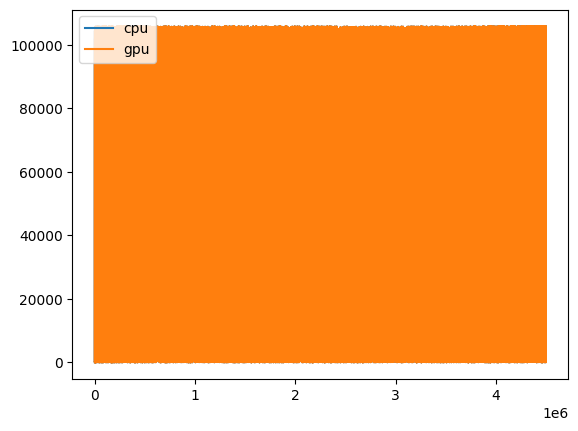

In [27]:
verify(host_jcn_loc, d_jcn_loc, decimal=7)

In [ ]:
verify(host_irn_loc, d_irn_loc, decimal=7)